<a href="https://colab.research.google.com/github/isabellachen3988/Fashionmnist-Visualization/blob/main/Clothing_Visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Import Libraries

In [ ]:
!pip install torchinfo

from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
import pandas as pd

from torch.nn import Module
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import ReLU
from torch.nn import LogSoftmax
from torch.nn import CrossEntropyLoss
from torch.nn import Dropout
from torch import flatten
import torch.optim as optim
import torch

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

import matplotlib.pyplot as plt
import numpy as np
import math

import scipy.stats as stats
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

torch.cuda.is_available()

True

Mount

In [ ]:
drive.mount('/content/drive')

Isabella File Import

In [ ]:
x_train = pd.read_csv(r'/content/drive/MyDrive/Grad Waterloo/ECE657A/Assignments/Asgn 3/ece657a-1221-asg3-fashionmnist-datafiles/x_train.csv')
x_test = pd.read_csv(r'/content/drive/MyDrive/Grad Waterloo/ECE657A/Assignments/Asgn 3/ece657a-1221-asg3-fashionmnist-datafiles/x_test.csv')
y_train = pd.read_csv(r'/content/drive/MyDrive/Grad Waterloo/ECE657A/Assignments/Asgn 3/ece657a-1221-asg3-fashionmnist-datafiles/y_train.csv')
y_test = pd.read_csv(r'/content/drive/MyDrive/Grad Waterloo/ECE657A/Assignments/Asgn 3/ece657a-1221-asg3-fashionmnist-datafiles/y_test.csv')

Xinran File Import

In [ ]:
x_train = pd.read_csv(r'/content/drive/MyDrive/Academics/Grad/ECE_657A/Assignment3/x_train.csv')
x_test = pd.read_csv(r'/content/drive/MyDrive/Academics/Grad/ECE_657A/Assignment3/x_test.csv')
y_train = pd.read_csv(r'/content/drive/MyDrive/Academics/Grad/ECE_657A/Assignment3/y_train.csv')
y_test = pd.read_csv(r'/content/drive/MyDrive/Academics/Grad/ECE_657A/Assignment3/y_test.csv')

#1.0 Default Network

Show sample image

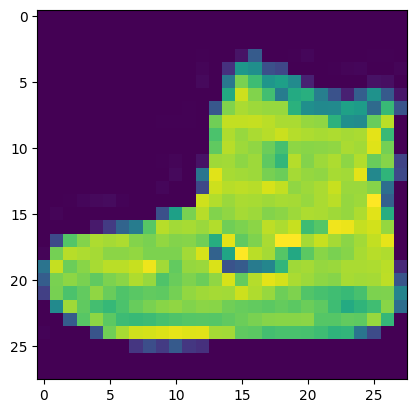

In [ ]:
plt.imshow(x_train.iloc[0].to_numpy().reshape((28,28)), interpolation='nearest')

Dataset

In [ ]:
# used for GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class MNISTDataset(Dataset):
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels

  def __len__(self):
    return self.images.shape[0]

  def __getitem__(self, idx):
    image = self.images.iloc[idx]
    label = self.labels.iloc[idx].to_numpy()[0]

    # reshape
    image = image.to_numpy().astype('float32').reshape((28,28))

    return image, label

mnist_dataset = MNISTDataset(images = x_train, labels = y_train)
train_data, val_data = torch.utils.data.random_split(mnist_dataset, [0.8, 0.2])
test_data = MNISTDataset(images = x_test, labels = y_test)

train_loader = DataLoader(train_data)
val_loader = DataLoader(val_data)
test_loader = DataLoader(test_data)

Create CNN Model



```
Initial Image Size: 1 x 28 x 28

After conv1: 32 x 28 x 28

After pool1: 32 x 14 x 14

After pool2: 32 x 7 x 7
```

Note that there is no softmax in the below summary. This is because CrossEntropyLoss criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class


In [ ]:
y_train.columns = ['label']
num_classes = len(y_train['label'].unique())

class CNN(Module):
  def __init__(self):
    super(CNN, self).__init__()

    # stride is default 1
    # in_channel = 1 due to gray image
    # out_channel = 32, since we apply 32 kernels
    self.conv1 = Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1)
    self.pool = MaxPool2d(kernel_size=2)
    self.conv2 = Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding=1)
    self.fc = Linear(32*7*7, num_classes)
    self.relu = ReLU()

  def forward(self,x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = x.view(1, -1)
    x = self.fc(x)
    return x

In [ ]:
LEARNING_RATE = 0.0001
model = CNN()

if torch.cuda.is_available():
  model = model.to(device)
criterion = CrossEntropyLoss() # this criterion performs softmax for us
optimizer = optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)

summary(model, input_size = (1, 1, 28, 28))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 5]                    --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─ReLU: 1-2                              [1, 32, 28, 28]           --
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Conv2d: 1-4                            [1, 32, 14, 14]           9,248
├─ReLU: 1-5                              [1, 32, 14, 14]           --
├─MaxPool2d: 1-6                         [1, 32, 7, 7]             --
├─Linear: 1-7                            [1, 5]                    7,845
Total params: 17,413
Trainable params: 17,413
Non-trainable params: 0
Total mult-adds (M): 2.07
Input size (MB): 0.00
Forward/backward pass size (MB): 0.25
Params size (MB): 0.07
Estimated Total Size (MB): 0.32

Helper Functions

In [ ]:
def convert_ms_to_min_sec(time_in_ms):
  time_min = math.floor(time_in_ms / (60 * 1000))
  time_sec = (time_in_ms / 1000) % 60
  return time_min, time_sec

def get_info(model, loader, data_len):
  correct = 0
  total = 0
  loss_tracker = 0
  for inputs, label in loader:
        if torch.cuda.is_available():
          inputs = inputs.to(device)
          label = label.to(device)
        output = model(inputs)
        loss = criterion(output, label)
        pred = output.max(1, keepdim=True)[1]

        loss_tracker += float(loss)
        correct += pred.eq(label.view_as(pred)).sum().item()
        total += inputs.shape[0]
  return correct / total, loss_tracker / data_len

Train the network

**Careful not to run this when you don't want to: training takes a while!**

epoch: 0, loss: 0.49649476685460575, acc: 0.8642291666666667, val acc: 0.86325, val loss: 0.4026228032753296
epoch: 1, loss: 0.3243422107986798, acc: 0.9006875, val acc: 0.8949166666666667, val loss: 0.302909120705299
epoch: 2, loss: 0.2914606759157938, acc: 0.9078125, val acc: 0.8983333333333333, val loss: 0.2910065794022992
epoch: 3, loss: 0.2785197587261834, acc: 0.9140833333333334, val acc: 0.90375, val loss: 0.281805291234215
epoch: 4, loss: 0.2671119507889844, acc: 0.91025, val acc: 0.903, val loss: 0.28448707588272
epoch: 5, loss: 0.2650536776940924, acc: 0.9139166666666667, val acc: 0.9024166666666666, val loss: 0.2823180376651416
epoch: 6, loss: 0.2577303018718547, acc: 0.9093125, val acc: 0.897, val loss: 0.32214117876722015
epoch: 7, loss: 0.25106316527193456, acc: 0.9207916666666667, val acc: 0.9060833333333334, val loss: 0.2779191508112092
epoch: 8, loss: 0.24457425396533866, acc: 0.9226041666666667, val acc: 0.9049166666666667, val loss: 0.2754350556488143
epoch: 9, loss:

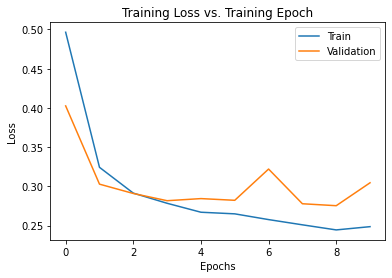

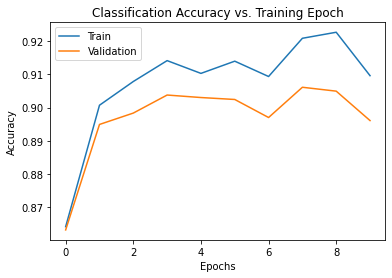

average runtime per epoch for training is : 1 min and 35.90527187500001 secs


In [ ]:
def get_train_accuracy(model, loader):
    correct = 0
    total = 0
    for inputs, label in train_loader:
        if torch.cuda.is_available():
          inputs = inputs.to(device)
          label = label.to(device)
        output = model(inputs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(label.view_as(pred)).sum().item()
        total += inputs.shape[0]
    return correct / total

EPOCHS = 10
total_time_in_ms = 0

train_loss, val_loss, train_acc, val_acc = [], [], [], []
for epoch in range(EPOCHS):
  loss_tracker = 0

  # record time for training on one epoch - works only for GPU
  start = torch.cuda.Event(enable_timing=True)
  end = torch.cuda.Event(enable_timing=True)
  start.record()

  for input, label in iter(train_loader):

    # GPU
    if torch.cuda.is_available():
      input = input.to(device)
      label = label.to(device)

    # forward pass
    outputs = model(input)

    # calculate loss
    loss = criterion(outputs, label)

    # backpropagation & update weights
    loss.backward()
    optimizer.step()
    optimizer.zero_grad() # clean up step for PyTorch

    # update tracked data
    loss_tracker += float(loss)

  end.record()
  torch.cuda.synchronize() # Waits for everything to finish running
  total_time_in_ms += start.elapsed_time(end)

  # calculate accuracy and save info to array and checkpoint
  train_loss_val = loss_tracker/len(train_data)
  train_acc_val = get_train_accuracy(model)
  val_acc_val, val_loss_val = get_info(model, val_loader, len(val_data))
  print("epoch: " + str(epoch) + ", loss: " + str(train_loss_val) + ", acc: " + str(train_acc_val) + ", val acc: " + str(val_acc_val) + ", val loss: " + str(val_loss_val))
  train_loss.append(train_loss_val)
  val_loss.append(val_loss_val)
  train_acc.append(train_acc_val)
  val_acc.append(val_acc_val)

  total_time_in_ms / (epoch + 1)
  time_min, time_sec = convert_ms_to_min_sec(total_time_in_ms)
  checkpoint = {
      'state_dict': model.state_dict(),
      'epoch': epoch,
      'train_loss': train_loss_val,
      'train_acc': train_acc_val,
      'val_loss': val_loss_val,
      'val_acc': val_acc_val,
      'runtime_min': time_min,
      'runtime_sec': time_sec
  }
  torch.save(checkpoint, "/content/drive/MyDrive/Grad Waterloo/ECE657A/Assignments/Asgn 3/saved_state/model_{0}_lr{1}_epoch{2}".format("CNN", LEARNING_RATE, epoch))

plt.title("Training Loss vs. Training Epoch")
plt.plot(list(range(EPOCHS)), train_loss, label="Train")
plt.plot(list(range(EPOCHS)), val_loss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("Classification Accuracy vs. Training Epoch")
plt.plot(list(range(EPOCHS)), train_acc, label="Train")
plt.plot(list(range(EPOCHS)), val_acc, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

avg_time_per_epoch_ms = total_time_in_ms / EPOCHS
time_min, time_sec = convert_ms_to_min_sec(avg_time_per_epoch_ms)
print("average runtime per epoch for training is : {} min and {} secs".format(time_min, time_sec))

## Test the model

Since the best model seems to arise from epoch = 2, we'll load it in and use the test dataset on it

In [ ]:
model_object = torch.load("/content/drive/MyDrive/Grad Waterloo/ECE657A/Assignments/Asgn 3/saved_state/model_CNN_lr0.0001_epoch2")
model.load_state_dict(model_object['state_dict'])

<All keys matched successfully>

In [ ]:
# record time for testing
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()

test_acc, test_loss = get_info(model, test_loader, len(test_data))

print("test accuracy: {}".format(test_acc))
print("test loss: {}".format(test_loss))

end.record()
torch.cuda.synchronize() # Waits for everything to finish running
test_time_ms = start.elapsed_time(end)

time_min, time_sec = convert_ms_to_min_sec(test_time_ms)
print("testing time: {} min and {} secs".format(time_min, time_sec))

test accuracy: 0.89
test loss: 0.32176706524746407
testing time: 0 min and 11.10094140625 secs


# 2.0 Your Own Network


### 2.1 CNN with modified kernal size, channel sizes and number of fully connected layers.

 ```
first convolutional layer: in_channels = 1, out_channels = 20, kernal size : 5 * 5, padding = 1
first pooling: kernal size: 2 * 2, stride = 2
second convolutional layer: in_channels = 20, out_channels = 50, kernal size : 4 * 4, padding = 1
second pooling: kernal size: 2 * 2, stride = 2
first fully connected layer: 50 * 6 * 6 to 128
second fully connected layer: 128 to number of classes
activation function: ReLU
 ```

In [ ]:
class CNN(Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = Conv2d(in_channels=1, out_channels=20, kernel_size=(5,5), padding=1)
    self.pool = MaxPool2d(kernel_size=2,stride = 2)
    self.conv2 = Conv2d(in_channels=20, out_channels=50, kernel_size=(4,4), padding=1)
    self.fc1 = Linear(50*6*6, 128)
    self.fc2 = Linear(128, num_classes)
    self.relu = ReLU()

  def forward(self,x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = x.view(1, -1)
    x = self.fc1(x)
    x = self.fc2(x)
    return x

In [ ]:
LEARNING_RATE = 0.0001
model_2 = CNN()

if torch.cuda.is_available():
  model_2 = model_2.to(device)
criterion = CrossEntropyLoss() # this criterion performs softmax for us
optimizer = optim.SGD(model_2.parameters(), lr=LEARNING_RATE, momentum=0.9)

summary(model_2, input_size = (1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 5]                    --
├─Conv2d: 1-1                            [1, 20, 26, 26]           520
├─ReLU: 1-2                              [1, 20, 26, 26]           --
├─MaxPool2d: 1-3                         [1, 20, 13, 13]           --
├─Conv2d: 1-4                            [1, 50, 12, 12]           16,050
├─ReLU: 1-5                              [1, 50, 12, 12]           --
├─MaxPool2d: 1-6                         [1, 50, 6, 6]             --
├─Linear: 1-7                            [1, 128]                  230,528
├─Linear: 1-8                            [1, 5]                    645
Total params: 247,743
Trainable params: 247,743
Non-trainable params: 0
Total mult-adds (M): 2.89
Input size (MB): 0.00
Forward/backward pass size (MB): 0.17
Params size (MB): 0.99
Estimated Total Size (MB): 1.16

Train the network

epoch: 0, loss: 0.35896639339682634, acc: 0.8846458333333334, val acc: 0.8771666666666667, val loss: 0.34495411491516054
epoch: 1, loss: 0.2658161151359263, acc: 0.8990416666666666, val acc: 0.8836666666666667, val loss: 0.3328464120581152
epoch: 2, loss: 0.24222247576552594, acc: 0.9159375, val acc: 0.8981666666666667, val loss: 0.29761610533696853
epoch: 3, loss: 0.2259817379646973, acc: 0.8964375, val acc: 0.87725, val loss: 0.38106421168214033
epoch: 4, loss: 0.21666582613630386, acc: 0.889, val acc: 0.8709166666666667, val loss: 0.44212600606310865
epoch: 5, loss: 0.21330657422509894, acc: 0.8924375, val acc: 0.87375, val loss: 0.44525312861434807
epoch: 6, loss: 0.20597411295311435, acc: 0.8937291666666667, val acc: 0.8714166666666666, val loss: 0.4733936683551116
epoch: 7, loss: 0.19831558722862228, acc: 0.9042916666666667, val acc: 0.8811666666666667, val loss: 0.40264973076472477
epoch: 8, loss: 0.19260321377943032, acc: 0.9086875, val acc: 0.8845, val loss: 0.3916142293398689

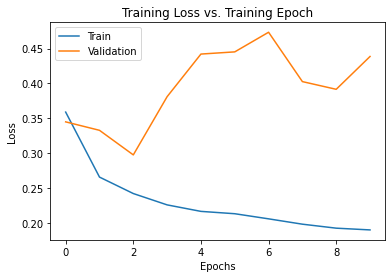

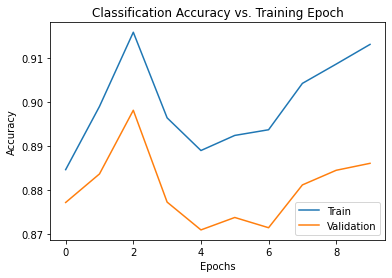

average runtime per epoch for training is : 1 min and 44.20333749999999 secs


In [ ]:
def get_train_accuracy(model, loader):
    correct = 0
    total = 0
    for inputs, label in train_loader:
        if torch.cuda.is_available():
          inputs = inputs.to(device)
          label = label.to(device)
        output = model(inputs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(label.view_as(pred)).sum().item()
        total += inputs.shape[0]
    return correct / total

EPOCHS = 10
total_time_in_ms = 0

train_loss, val_loss, train_acc, val_acc = [], [], [], []
for epoch in range(EPOCHS):
  loss_tracker = 0

  # record time for training on one epoch - works only for GPU
  start = torch.cuda.Event(enable_timing=True)
  end = torch.cuda.Event(enable_timing=True)
  start.record()

  for input, label in iter(train_loader):

    # GPU
    if torch.cuda.is_available():
      input = input.to(device)
      label = label.to(device)

    # forward pass
    outputs = model_2(input)

    # calculate loss
    loss = criterion(outputs, label)

    # backpropagation & update weights
    loss.backward()
    optimizer.step()
    optimizer.zero_grad() # clean up step for PyTorch

    # update tracked data
    loss_tracker += float(loss)

  end.record()
  torch.cuda.synchronize() # Waits for everything to finish running
  total_time_in_ms += start.elapsed_time(end)

  # calculate accuracy and save info to array and checkpoint
  train_loss_val = loss_tracker/len(train_data)
  train_acc_val = get_train_accuracy(model_2,train_loader)
  val_acc_val, val_loss_val = get_info(model_2, val_loader, len(val_data))
  print("epoch: " + str(epoch) + ", loss: " + str(train_loss_val) + ", acc: " + str(train_acc_val) + ", val acc: " + str(val_acc_val) + ", val loss: " + str(val_loss_val))
  train_loss.append(train_loss_val)
  val_loss.append(val_loss_val)
  train_acc.append(train_acc_val)
  val_acc.append(val_acc_val)

  total_time_in_ms / (epoch + 1)
  time_min, time_sec = convert_ms_to_min_sec(total_time_in_ms)
  checkpoint = {
      'state_dict': model_2.state_dict(),
      'epoch': epoch,
      'train_loss': train_loss_val,
      'train_acc': train_acc_val,
      'val_loss': val_loss_val,
      'val_acc': val_acc_val,
      'runtime_min': time_min,
      'runtime_sec': time_sec
  }
  torch.save(checkpoint, "/content/drive/MyDrive/Academics/Grad/ECE_657A/Assignment3/saved_state/model_2_{0}_lr{1}_epoch{2}".format("CNN", LEARNING_RATE, epoch))

plt.title("Training Loss vs. Training Epoch")
plt.plot(list(range(EPOCHS)), train_loss, label="Train")
plt.plot(list(range(EPOCHS)), val_loss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("Classification Accuracy vs. Training Epoch")
plt.plot(list(range(EPOCHS)), train_acc, label="Train")
plt.plot(list(range(EPOCHS)), val_acc, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

avg_time_per_epoch_ms = total_time_in_ms / EPOCHS
time_min, time_sec = convert_ms_to_min_sec(avg_time_per_epoch_ms)
print("average runtime per epoch for training is : {} min and {} secs".format(time_min, time_sec))

Test the model

Choose: Epoch = 2

In [ ]:
model_object = torch.load("/content/drive/MyDrive/Academics/Grad/ECE_657A/Assignment3/saved_state/model_2_CNN_lr0.0001_epoch2")
model_2.load_state_dict(model_object['state_dict'])

<All keys matched successfully>

In [ ]:
# record time for testing
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()

test_acc, test_loss = get_info(model_2, test_loader, len(test_data))

print("test accuracy: {}".format(test_acc))
print("test loss: {}".format(test_loss))

end.record()
torch.cuda.synchronize() # Waits for everything to finish running
test_time_ms = start.elapsed_time(end)

time_min, time_sec = convert_ms_to_min_sec(test_time_ms)
print("testing time: {} min and {} secs".format(time_min, time_sec))

test accuracy: 0.8971
test loss: 0.3047274206422736
testing time: 0 min and 16.7988671875 secs


## 2.2

 ```
first convolutional layer: in_channels = 1, out_channels = 32, kernal size : 3 * 3, padding = 1
first pooling: kernal size: 2 * 2, stride = 1
first drop out ratio: 0.2
second convolutional layer: in_channels = 32, out_channels = 32, kernal size : 3 * 3, padding = 1
first fully connected layer: 32 * 7 * 7 to 200
second drop out ratio: 0.2
second fully connected layer: 200 to number of classes
activation function: ReLU
 ```

In [ ]:
class CNN(Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = Conv2d(in_channels=1, out_channels=32, kernel_size=(3,3), padding=1)
    self.pool = MaxPool2d(kernel_size=2)
    self.conv2 = Conv2d(in_channels=32, out_channels=32, kernel_size=(3,3), padding=1)
    self.fc1 = Linear(32*7*7, 200)
    self.fc2 = Linear(200, num_classes)
    self.relu = ReLU()
    self.dropout = Dropout(0.2)

  def forward(self,x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.dropout(x)
    x = self.pool(self.relu(self.conv2(x)))
    x = x.view(1, -1)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [ ]:
LEARNING_RATE = 0.0001
model_3 = CNN()

if torch.cuda.is_available():
  model_3 = model_3.to(device)
criterion = CrossEntropyLoss() # this criterion performs softmax for us
optimizer = optim.SGD(model_3.parameters(), lr=LEARNING_RATE, momentum=0.9)

summary(model_3, input_size = (1, 1, 28, 28))

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 5]                    --
├─Conv2d: 1-1                            [1, 32, 28, 28]           320
├─ReLU: 1-2                              [1, 32, 28, 28]           --
├─MaxPool2d: 1-3                         [1, 32, 14, 14]           --
├─Dropout: 1-4                           [1, 32, 14, 14]           --
├─Conv2d: 1-5                            [1, 32, 14, 14]           9,248
├─ReLU: 1-6                              [1, 32, 14, 14]           --
├─MaxPool2d: 1-7                         [1, 32, 7, 7]             --
├─Linear: 1-8                            [1, 200]                  313,800
├─ReLU: 1-9                              [1, 200]                  --
├─Dropout: 1-10                          [1, 200]                  --
├─Linear: 1-11                           [1, 5]                    1,005
Total params: 324,373
Trainable params: 324,373
Non-trainable params: 0
T

**Model Training:**

epoch: 0, loss: 0.4194231279848335, acc: 0.8903333333333333, val acc: 0.8893333333333333, val loss: 0.29145905571347286
epoch: 1, loss: 0.28949741080409896, acc: 0.90575, val acc: 0.9035, val loss: 0.2644254647443559
epoch: 2, loss: 0.25249037077597336, acc: 0.918875, val acc: 0.9123333333333333, val loss: 0.2499607371033222
epoch: 3, loss: 0.23373238772599045, acc: 0.9254791666666666, val acc: 0.91625, val loss: 0.23070228090558487
epoch: 4, loss: 0.21967620570913707, acc: 0.9282291666666667, val acc: 0.9184166666666667, val loss: 0.22373100899848414
epoch: 5, loss: 0.21092496988088472, acc: 0.9275833333333333, val acc: 0.9185833333333333, val loss: 0.24226366480089276
epoch: 6, loss: 0.20091521393068612, acc: 0.9323958333333333, val acc: 0.9185833333333333, val loss: 0.23700400178432218
epoch: 7, loss: 0.19423543618279945, acc: 0.9322083333333333, val acc: 0.91925, val loss: 0.2388705629397048
epoch: 8, loss: 0.18954310616882764, acc: 0.9352708333333334, val acc: 0.9206666666666666, 

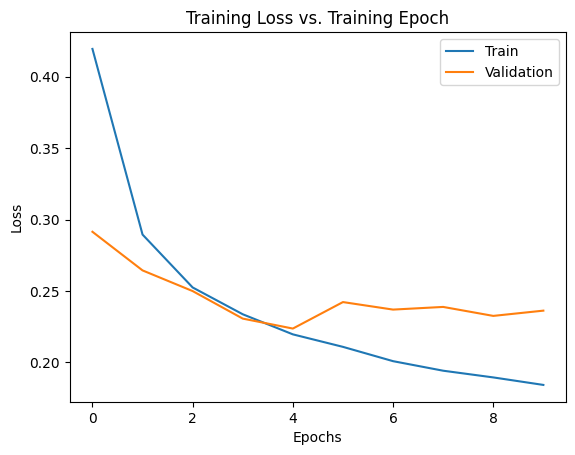

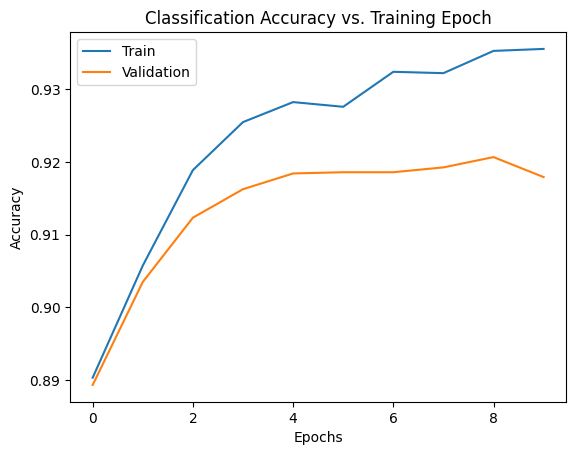

average runtime per epoch for training is : 1 min and 50.77936093749999 secs


In [ ]:
def get_train_accuracy(model, loader):
    correct = 0
    total = 0
    for inputs, label in train_loader:
        if torch.cuda.is_available():
          inputs = inputs.to(device)
          label = label.to(device)
        output = model(inputs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(label.view_as(pred)).sum().item()
        total += inputs.shape[0]
    return correct / total

EPOCHS = 10
total_time_in_ms = 0

train_loss, val_loss, train_acc, val_acc = [], [], [], []
for epoch in range(EPOCHS):
  loss_tracker = 0

  # record time for training on one epoch - works only for GPU
  start = torch.cuda.Event(enable_timing=True)
  end = torch.cuda.Event(enable_timing=True)
  start.record()

  for input, label in iter(train_loader):

    # GPU
    if torch.cuda.is_available():
      input = input.to(device)
      label = label.to(device)

    # forward pass
    outputs = model_3(input)

    # calculate loss
    loss = criterion(outputs, label)

    # backpropagation & update weights
    loss.backward()
    optimizer.step()
    optimizer.zero_grad() # clean up step for PyTorch

    # update tracked data
    loss_tracker += float(loss)

  end.record()
  torch.cuda.synchronize() # Waits for everything to finish running
  total_time_in_ms += start.elapsed_time(end)

  # calculate accuracy and save info to array and checkpoint
  train_loss_val = loss_tracker/len(train_data)
  train_acc_val = get_train_accuracy(model_3,train_loader)
  val_acc_val, val_loss_val = get_info(model_3, val_loader, len(val_data))
  print("epoch: " + str(epoch) + ", loss: " + str(train_loss_val) + ", acc: " + str(train_acc_val) + ", val acc: " + str(val_acc_val) + ", val loss: " + str(val_loss_val))
  train_loss.append(train_loss_val)
  val_loss.append(val_loss_val)
  train_acc.append(train_acc_val)
  val_acc.append(val_acc_val)

  total_time_in_ms / (epoch + 1)
  time_min, time_sec = convert_ms_to_min_sec(total_time_in_ms)
  checkpoint = {
      'state_dict': model_3.state_dict(),
      'epoch': epoch,
      'train_loss': train_loss_val,
      'train_acc': train_acc_val,
      'val_loss': val_loss_val,
      'val_acc': val_acc_val,
      'runtime_min': time_min,
      'runtime_sec': time_sec
  }
  torch.save(checkpoint, "/content/drive/MyDrive/Academics/Grad/ECE_657A/Assignment3/saved_state/model_3_{0}_lr{1}_epoch{2}".format("CNN", LEARNING_RATE, epoch))

plt.title("Training Loss vs. Training Epoch")
plt.plot(list(range(EPOCHS)), train_loss, label="Train")
plt.plot(list(range(EPOCHS)), val_loss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("Classification Accuracy vs. Training Epoch")
plt.plot(list(range(EPOCHS)), train_acc, label="Train")
plt.plot(list(range(EPOCHS)), val_acc, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

avg_time_per_epoch_ms = total_time_in_ms / EPOCHS
time_min, time_sec = convert_ms_to_min_sec(avg_time_per_epoch_ms)
print("average runtime per epoch for training is : {} min and {} secs".format(time_min, time_sec))

Test the model

Choose: Epoch = 4

In [ ]:
model_object = torch.load("/content/drive/MyDrive/Academics/Grad/ECE_657A/Assignment3/saved_state/model_3_CNN_lr0.0001_epoch4")
model_3.load_state_dict(model_object['state_dict'])

<All keys matched successfully>

In [ ]:
# record time for testing
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()

test_acc, test_loss = get_info(model_3, test_loader, len(test_data))

print("test accuracy: {}".format(test_acc))
print("test loss: {}".format(test_loss))

end.record()
torch.cuda.synchronize() # Waits for everything to finish running
test_time_ms = start.elapsed_time(end)

time_min, time_sec = convert_ms_to_min_sec(test_time_ms)
print("testing time: {} min and {} secs".format(time_min, time_sec))

test accuracy: 0.9111
test loss: 0.2536168471418992
testing time: 0 min and 12.0472216796875 secs


## 2.3

 ```
first convolutional layer: in_channels = 1, out_channels = 16, kernal size : 3 * 3, padding = 1
first pooling: kernal size: 2 * 2, stride = 1
second convolutional layer: in_channels = 16, out_channels = 16, kernal size : 3 * 3, padding = 1
first fully connected layer: 16 * 7 * 7 to 100
second drop out ratio: 0.25
second fully connected layer: 100 to number of classes
activation function: ReLU
 ```

In [ ]:
class CNN(Module):
  def __init__(self):
    super(CNN, self).__init__()

    self.conv1 = Conv2d(in_channels=1, out_channels=16, kernel_size=(3,3), padding=1)
    self.pool = MaxPool2d(kernel_size=2)
    self.conv2 = Conv2d(in_channels=16, out_channels=16, kernel_size=(3,3), padding=1)
    self.fc1 = Linear(16*7*7, 100)
    self.fc2 = Linear(100, num_classes)
    self.relu = ReLU()
    self.dropout = Dropout(0.25)

  def forward(self,x):
    x = self.pool(self.relu(self.conv1(x)))
    x = self.pool(self.relu(self.conv2(x)))
    x = x.view(1, -1)
    x = self.fc1(x)
    x = self.relu(x)
    x = self.dropout(x)
    x = self.fc2(x)
    return x

In [ ]:
LEARNING_RATE = 0.0001
model_4 = CNN()

if torch.cuda.is_available():
  model_4 = model_4.to(device)
criterion = CrossEntropyLoss() # this criterion performs softmax for us
optimizer = optim.SGD(model_4.parameters(), lr=LEARNING_RATE, momentum=0.9)

summary(model_4, input_size = (1, 1, 28, 28))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 5]                    --
├─Conv2d: 1-1                            [1, 16, 28, 28]           160
├─ReLU: 1-2                              [1, 16, 28, 28]           --
├─MaxPool2d: 1-3                         [1, 16, 14, 14]           --
├─Conv2d: 1-4                            [1, 16, 14, 14]           2,320
├─ReLU: 1-5                              [1, 16, 14, 14]           --
├─MaxPool2d: 1-6                         [1, 16, 7, 7]             --
├─Linear: 1-7                            [1, 100]                  78,500
├─ReLU: 1-8                              [1, 100]                  --
├─Dropout: 1-9                           [1, 100]                  --
├─Linear: 1-10                           [1, 5]                    505
Total params: 81,485
Trainable params: 81,485
Non-trainable params: 0
Total mult-adds (M): 0.66
Input size (MB): 0.00
Forward/backward pass size (

**Model Training:**

epoch: 0, loss: 0.3969507094133422, acc: 0.8915833333333333, val acc: 0.8889166666666667, val loss: 0.30271811548602884
epoch: 1, loss: 0.29525250574148304, acc: 0.9001875, val acc: 0.89575, val loss: 0.2847174081844563
epoch: 2, loss: 0.26782148319431415, acc: 0.91225, val acc: 0.90475, val loss: 0.2585401919005016
epoch: 3, loss: 0.24837373317134248, acc: 0.9181875, val acc: 0.9081666666666667, val loss: 0.262446277758966
epoch: 4, loss: 0.23814290154188547, acc: 0.9227916666666667, val acc: 0.9144166666666667, val loss: 0.2526077118637417
epoch: 5, loss: 0.22749947978962495, acc: 0.9193541666666667, val acc: 0.9083333333333333, val loss: 0.2681967859609109
epoch: 6, loss: 0.22458180673453876, acc: 0.9232083333333333, val acc: 0.912, val loss: 0.2578753385079439
epoch: 7, loss: 0.21799496968133683, acc: 0.922875, val acc: 0.9090833333333334, val loss: 0.2665543358398785
epoch: 8, loss: 0.20693743047216237, acc: 0.9298333333333333, val acc: 0.9135, val loss: 0.2575657627730623
epoch: 

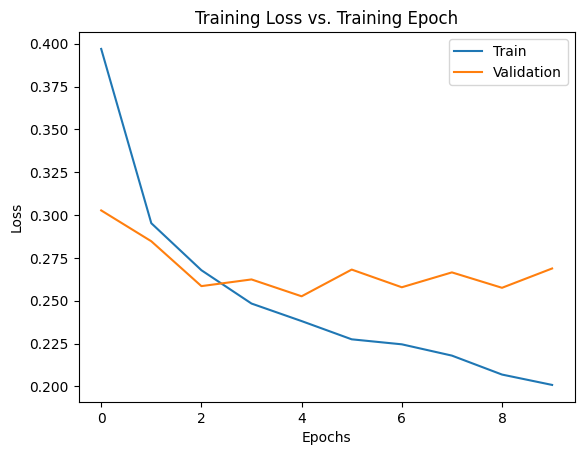

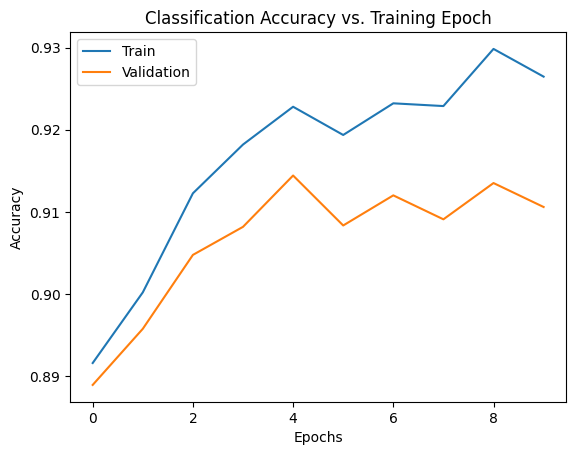

average runtime per epoch for training is : 1 min and 46.040982031249996 secs


In [ ]:
def get_train_accuracy(model, loader):
    correct = 0
    total = 0
    for inputs, label in train_loader:
        if torch.cuda.is_available():
          inputs = inputs.to(device)
          label = label.to(device)
        output = model(inputs)
        pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        correct += pred.eq(label.view_as(pred)).sum().item()
        total += inputs.shape[0]
    return correct / total

EPOCHS = 10
total_time_in_ms = 0

train_loss, val_loss, train_acc, val_acc = [], [], [], []
for epoch in range(EPOCHS):
  loss_tracker = 0

  # record time for training on one epoch - works only for GPU
  start = torch.cuda.Event(enable_timing=True)
  end = torch.cuda.Event(enable_timing=True)
  start.record()

  for input, label in iter(train_loader):

    # GPU
    if torch.cuda.is_available():
      input = input.to(device)
      label = label.to(device)

    # forward pass
    outputs = model_4(input)

    # calculate loss
    loss = criterion(outputs, label)

    # backpropagation & update weights
    loss.backward()
    optimizer.step()
    optimizer.zero_grad() # clean up step for PyTorch

    # update tracked data
    loss_tracker += float(loss)

  end.record()
  torch.cuda.synchronize() # Waits for everything to finish running
  total_time_in_ms += start.elapsed_time(end)

  # calculate accuracy and save info to array and checkpoint
  train_loss_val = loss_tracker/len(train_data)
  train_acc_val = get_train_accuracy(model_4,train_loader)
  val_acc_val, val_loss_val = get_info(model_4, val_loader, len(val_data))
  print("epoch: " + str(epoch) + ", loss: " + str(train_loss_val) + ", acc: " + str(train_acc_val) + ", val acc: " + str(val_acc_val) + ", val loss: " + str(val_loss_val))
  train_loss.append(train_loss_val)
  val_loss.append(val_loss_val)
  train_acc.append(train_acc_val)
  val_acc.append(val_acc_val)

  total_time_in_ms / (epoch + 1)
  time_min, time_sec = convert_ms_to_min_sec(total_time_in_ms)
  checkpoint = {
      'state_dict': model_4.state_dict(),
      'epoch': epoch,
      'train_loss': train_loss_val,
      'train_acc': train_acc_val,
      'val_loss': val_loss_val,
      'val_acc': val_acc_val,
      'runtime_min': time_min,
      'runtime_sec': time_sec
  }
  torch.save(checkpoint, "/content/drive/MyDrive/Academics/Grad/ECE_657A/Assignment3/saved_state/model_4_{0}_lr{1}_epoch{2}".format("CNN", LEARNING_RATE, epoch))

plt.title("Training Loss vs. Training Epoch")
plt.plot(list(range(EPOCHS)), train_loss, label="Train")
plt.plot(list(range(EPOCHS)), val_loss, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc='best')
plt.show()

plt.title("Classification Accuracy vs. Training Epoch")
plt.plot(list(range(EPOCHS)), train_acc, label="Train")
plt.plot(list(range(EPOCHS)), val_acc, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(loc='best')
plt.show()

avg_time_per_epoch_ms = total_time_in_ms / EPOCHS
time_min, time_sec = convert_ms_to_min_sec(avg_time_per_epoch_ms)
print("average runtime per epoch for training is : {} min and {} secs".format(time_min, time_sec))

Test the model

Choose: Epoch = 4

In [ ]:
model_object = torch.load("/content/drive/MyDrive/Academics/Grad/ECE_657A/Assignment3/saved_state/model_4_CNN_lr0.0001_epoch4")
model_4.load_state_dict(model_object['state_dict'])

<All keys matched successfully>

In [ ]:
# record time for testing
start = torch.cuda.Event(enable_timing=True)
end = torch.cuda.Event(enable_timing=True)
start.record()

test_acc, test_loss = get_info(model_4, test_loader, len(test_data))

print("test accuracy: {}".format(test_acc))
print("test loss: {}".format(test_loss))

end.record()
torch.cuda.synchronize() # Waits for everything to finish running
test_time_ms = start.elapsed_time(end)

time_min, time_sec = convert_ms_to_min_sec(test_time_ms)
print("testing time: {} min and {} secs".format(time_min, time_sec))

test accuracy: 0.9018
test loss: 0.2814638281620365
testing time: 0 min and 11.64785546875 secs


# 4.0 Using Your Own Encoding

## 4.1 PCA

Get encoding from model

In [ ]:
def get_encoding(model, loader, is_train = True):
  df_encoding = pd.DataFrame()
  if (is_train == False):
    df_label = pd.DataFrame()
    df_input = pd.DataFrame()
  for inputs, label in loader:
        if (is_train == False):
          pd_row = pd.DataFrame(inputs.view(1, -1).numpy())
          df_input = pd.concat([df_input, pd_row])

        if torch.cuda.is_available():
          inputs = inputs.to(device)
          label = label.to(device)
        output = model(inputs)

        if torch.cuda.is_available():
          output = output.cpu()
          label = label.cpu()

        # since tensor output requires grad, call detach
        pd_row = pd.DataFrame(output.detach().numpy())
        df_encoding = pd.concat([df_encoding, pd_row])

        if (is_train == False):
          pd_row = pd.DataFrame(label.detach().numpy())
          df_label = pd.concat([df_label, pd_row])

  if (is_train):
    return df_encoding
  else:
    return df_encoding, df_label, df_input


In [ ]:
train_encoding = get_encoding(model_3, train_loader)
test_encoding, label, input = get_encoding(model_3, test_loader, False)
label.columns = ['label']

Apply PCA

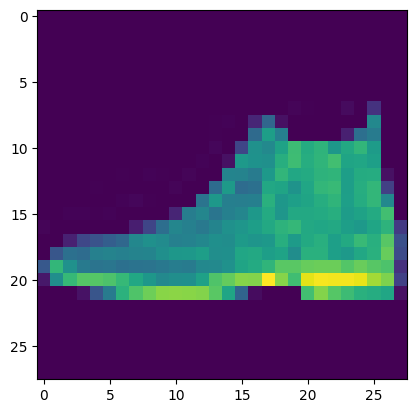

In [ ]:
plt.imshow(input.iloc[0].to_numpy().reshape((28,28)), interpolation='nearest')

In [ ]:
train_encoding.head()

,0,1,2,3,4
0,0.321532,0.085173,0.358114,-0.412292,-0.031917
0,-2.305349,0.336380,-1.349565,0.237068,2.872394
0,-3.276173,4.548977,-1.618643,-0.135274,-0.998636
0,-0.369253,1.968577,-0.532588,-0.112308,-0.247814
0,-0.456377,0.290269,-0.296212,0.235591,-0.319890


In [ ]:
train_encoding = train_encoding.select_dtypes(include="number").apply(stats.zscore)
test_encoding = test_encoding.select_dtypes(include="number").apply(stats.zscore)
pca_CNN = PCA()
CNN_train_pca = pca_CNN.fit_transform(train_encoding)
CNN_test_pca = pca_CNN.transform(test_encoding)

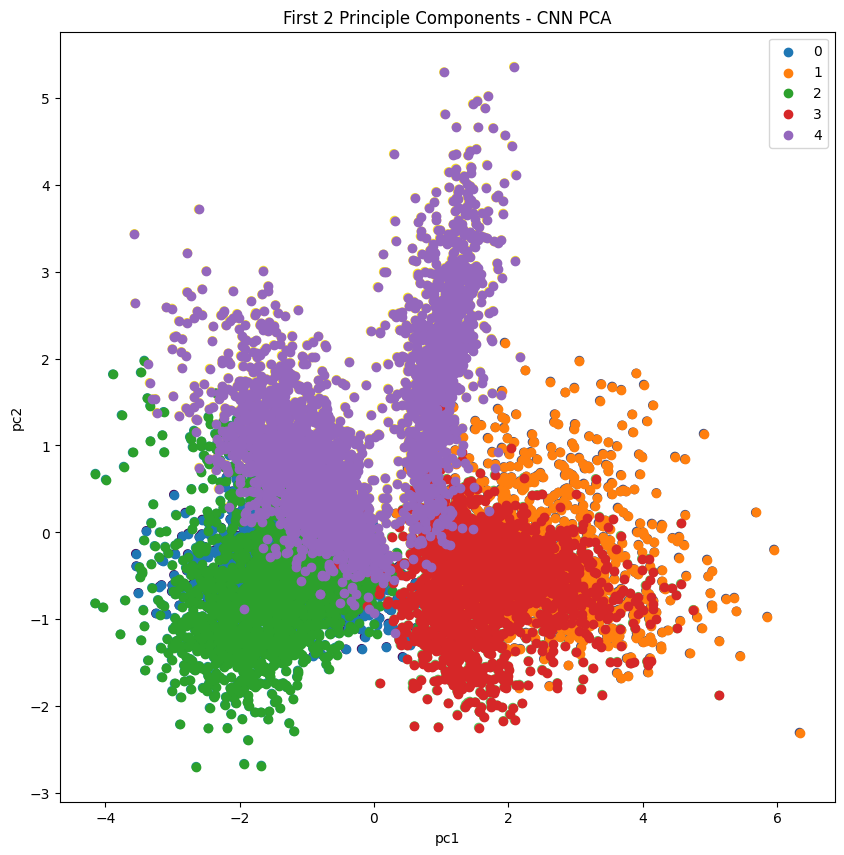

In [ ]:
plt.figure(figsize=(10,10))
plt.scatter(CNN_test_pca[:,0], CNN_test_pca[:,1], c=label['label'])
plt.title("First 2 Principle Components - CNN PCA")
plt.xlabel('pc1')
plt.ylabel('pc2')
PCA_labels = np.sort(label['label'].unique())

for q, PCA_labels in enumerate(PCA_labels):
  plt.scatter(CNN_test_pca[label['label'] == q, 0], CNN_test_pca[label['label'] == q,1], label = PCA_labels)
plt.legend(loc="upper right")

## 4.2 DBSCAN

Unique clusters: 5


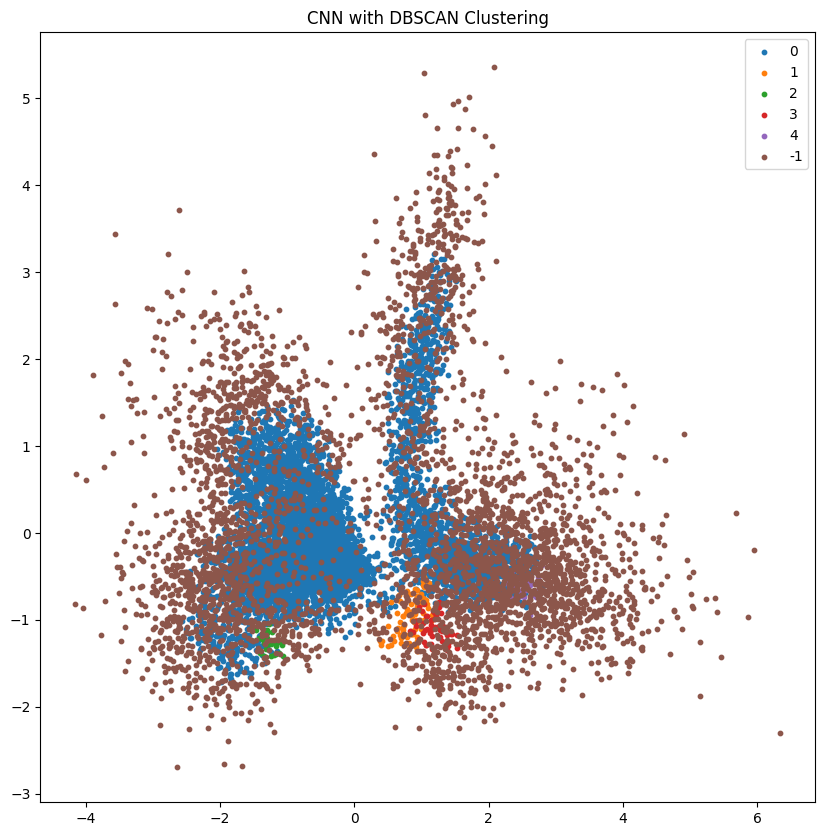

In [ ]:
dbscan_pred = DBSCAN(eps=0.29, min_samples=18).fit(CNN_test_pca)
dbscan_labels = dbscan_pred.labels_

# len is -1 because there is an additional label -1 that labels noisy points not assigned to any cluster
clusters = len(set(dbscan_labels)) - 1
print("Unique clusters: {}".format(clusters))

plt.figure(figsize=(10,10))
plt.title("CNN with DBSCAN Clustering")

for i in set(dbscan_labels):
    plt.scatter(CNN_test_pca[dbscan_labels == i , 0] , CNN_test_pca[dbscan_labels == i , 1] , label = i, s=10)
plt.legend()

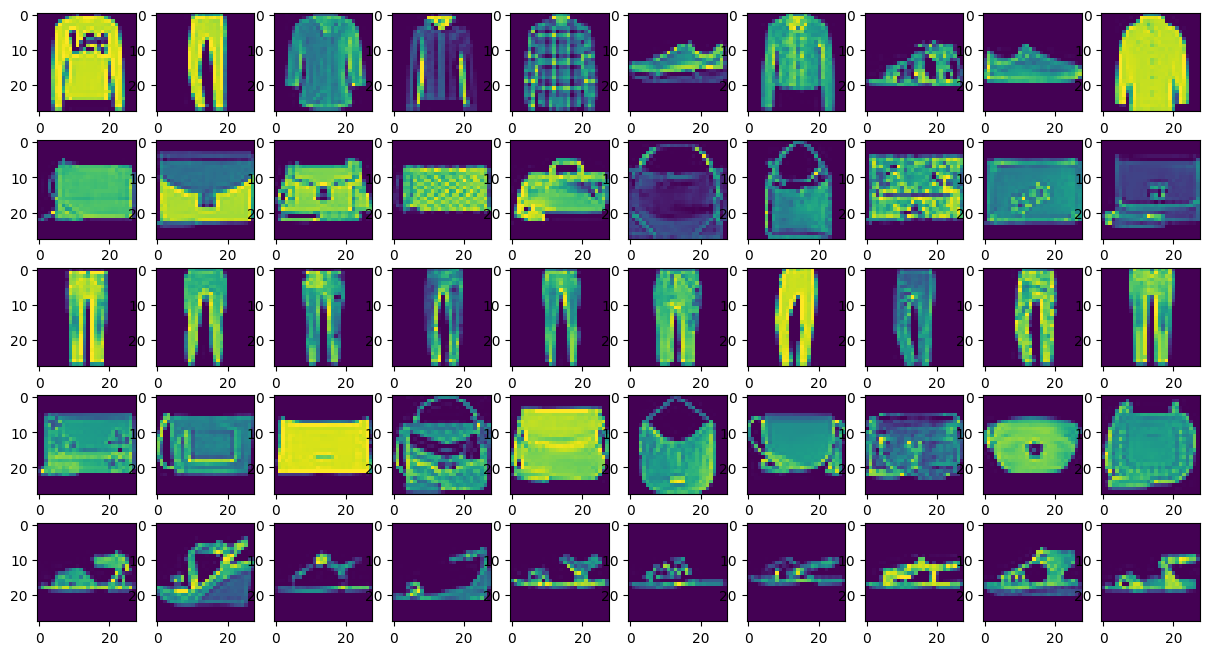

In [ ]:
NUM_SAMPLES = 10

fig = plt.figure(figsize=(15, 8))
columns = NUM_SAMPLES
rows = clusters
for i in set(dbscan_labels):
  if i >= 0:
    for j in range(NUM_SAMPLES):
      img = input[dbscan_labels == i].head(n=NUM_SAMPLES).iloc[j].to_numpy().reshape(28,28)
      fig.add_subplot(rows, columns, i * 10 + j + 1)
      plt.imshow(img, interpolation='nearest')

## 4.3 K-Means

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


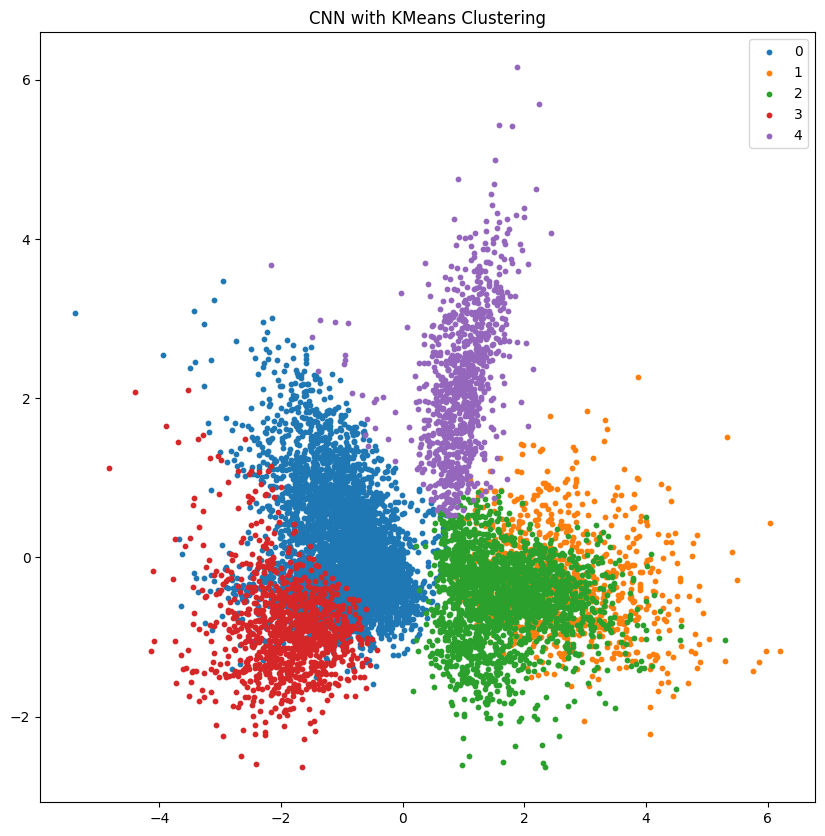

In [ ]:
clusters = 5

kmeans = KMeans(n_clusters = clusters)
kmeans_label = kmeans.fit_predict(CNN_test_pca)
u_kmeans_label = np.unique(kmeans_label)

plt.figure(figsize=(10,10))
plt.title("CNN with KMeans Clustering")
for i in u_kmeans_label:
    plt.scatter(CNN_test_pca[kmeans_label == i , 0] , CNN_test_pca[kmeans_label == i , 1] , label = i, s=10)
plt.legend()
plt.show()

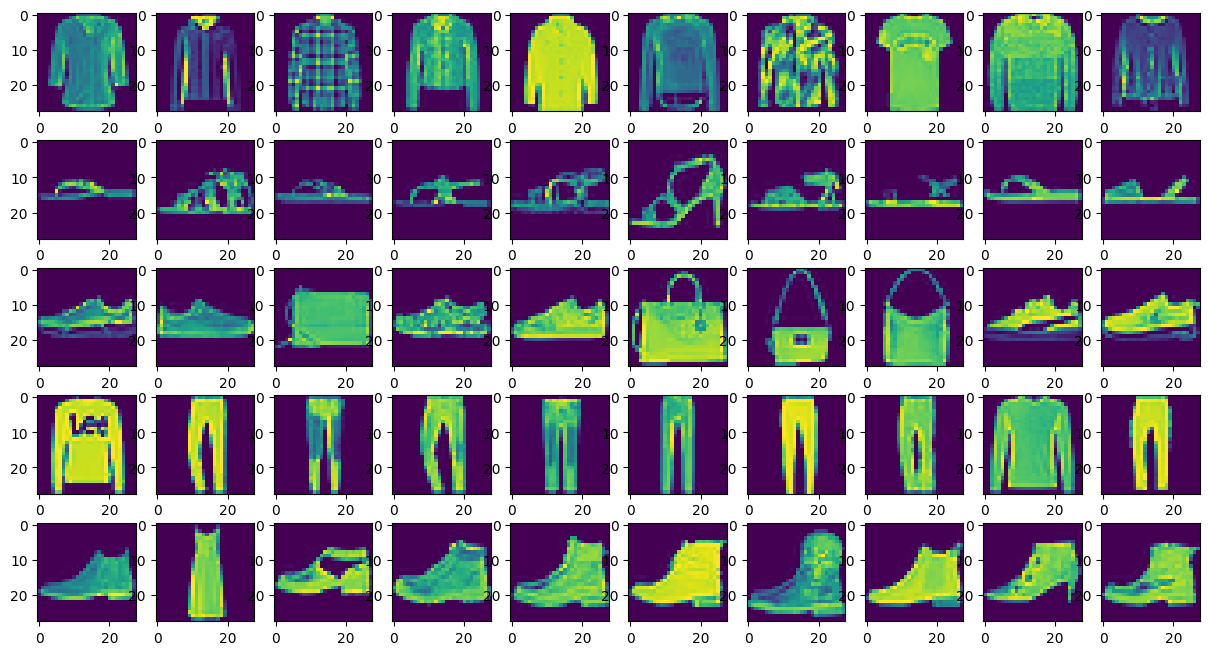

In [ ]:
NUM_SAMPLES = 10

fig = plt.figure(figsize=(15, 8))
columns = NUM_SAMPLES
rows = clusters
for i in u_kmeans_label:
  for j in range(NUM_SAMPLES):
    img = input[kmeans_label == i].head(n=NUM_SAMPLES).iloc[j].to_numpy().reshape(28,28)
    fig.add_subplot(rows, columns, i * 10 + j + 1)
    plt.imshow(img)

## 4.4 t-SNE

In [ ]:
tsne = TSNE()

In [ ]:
train_encoding = train_encoding.select_dtypes(include="number").apply(stats.zscore)
test_encoding = test_encoding.select_dtypes(include="number").apply(stats.zscore)

In [ ]:
CNN_train_tsne = tsne.fit_transform(train_encoding)
CNN_test_tsne = tsne.fit_transform(test_encoding)

Text(0, 0.5, 't-sne 2')

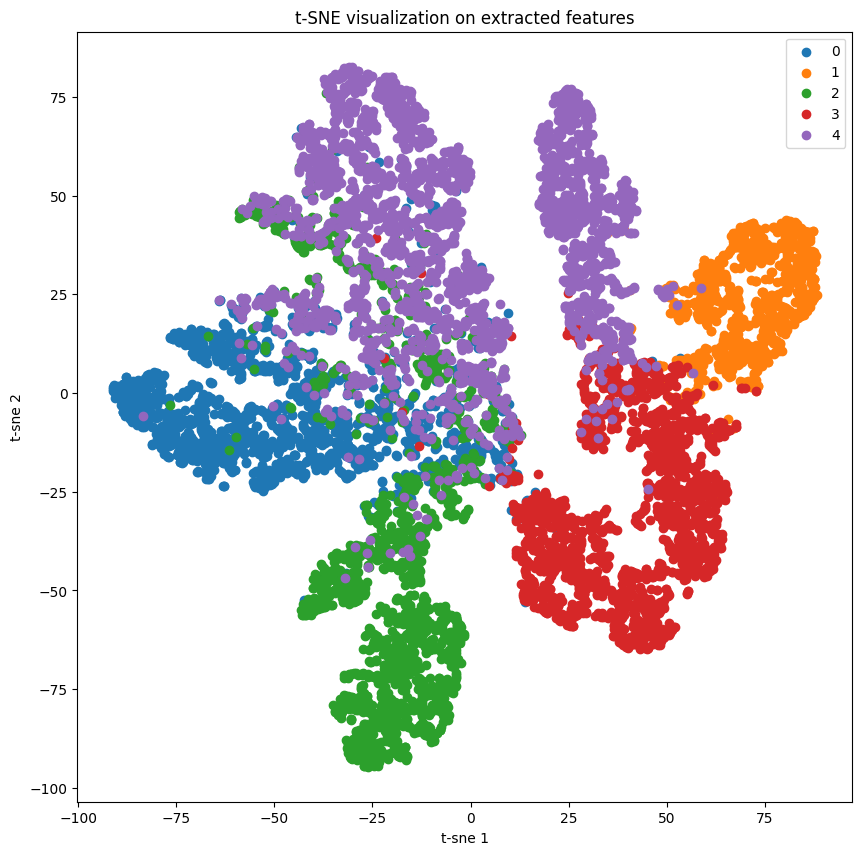

In [ ]:
Label_ = np.unique(label['label'].unique())
plt.figure(figsize=(10,10))
for l,Label_ in enumerate(Label_):
  plt.scatter(CNN_test_tsne[label['label'] == l, 0], CNN_test_tsne[label['label'] == l,1], label = Label_)
plt.title('t-SNE visualization on extracted features')
plt.legend(loc="upper right")
plt.xlabel('t-sne 1')
plt.ylabel('t-sne 2')

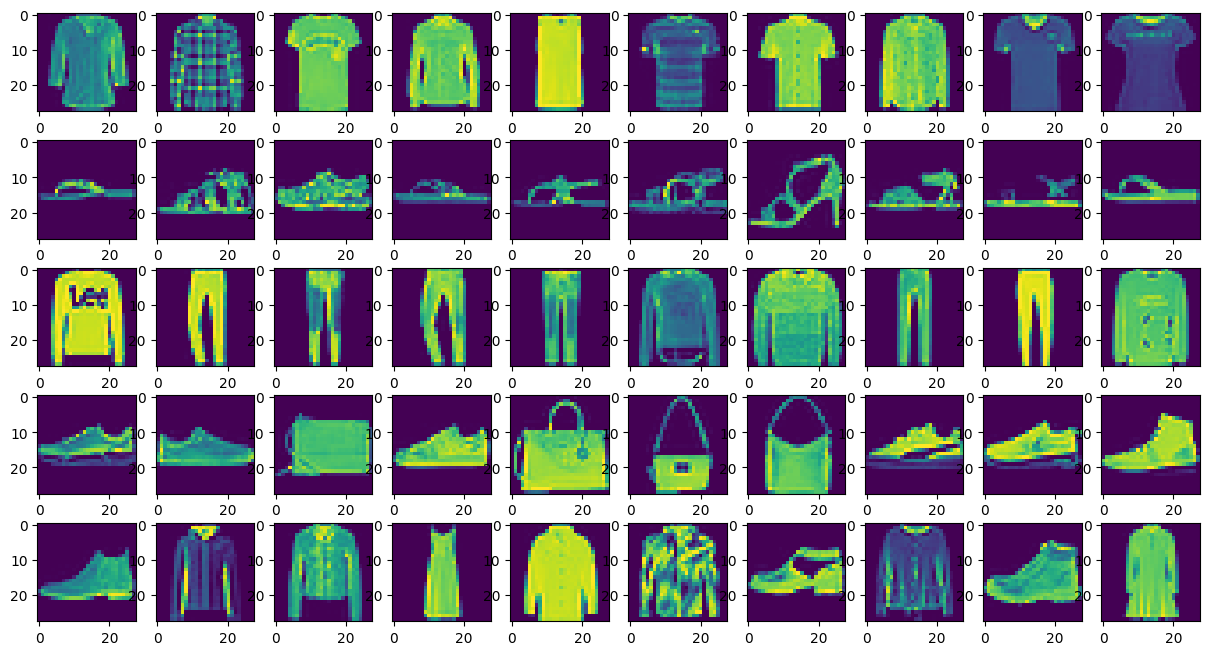

In [ ]:
NUM_SAMPLES = 10

fig = plt.figure(figsize=(15, 8))
columns = NUM_SAMPLES
rows = clusters
for i in range(Label_+1):
  if i >= 0:
    for j in range(NUM_SAMPLES):
      img = input[label['label'] == i].head(n=NUM_SAMPLES).iloc[j].to_numpy().reshape(28,28)
      fig.add_subplot(rows, columns, i * 10 + j + 1)
      plt.imshow(img, interpolation='nearest')

According to the results of the clustering algorithms, we think the clothes can be categorized into the following 5 categories:

1. Shirts
2. Open-toed Shoes
3. Long pants and long-sleeved shirts
4. Runners and handbags
5. Jackets, dresses and lowrise boots

These results are taken from t-SNE algorithm. K-means algorithm suggests similar results, but the only difference is that the last category it suggested doesn't include jackets, but instead includes all types of boots.

The result of DBSCAN is not informative because it categorized many datapoints into one category, split one specific category into two (purses), and left a lot of clothes uncategorized.